# Zadanie 2

## ZADANIE NALEŻY WYKONAĆ SAMODZIELNIE

## NIEDOZWOLONE JEST KOPIOWANIE GOTOWEGO KODU

## PROSZĘ PRZECZYTAĆ NOTEBOOK "ZADANIA_DOMOWE_HOWTO"

## TERMIN: 11 LISTOPADA 2018 R. GODZ. 23:59

Zaimplementować klasy:

`Sum`, `MatrixDotMatrix`, `SquaredL2Error`, `CrossEntropyWithLogits`

Klasa `Sum` przyjmuje dwa węzły: `a` oraz `b`. Oba mogą mieć dowolny (ale ten sam) shape. Klasa implementuje dodawanie element-wise.

Klasa `MatrixDotMatrix` przyjmuje dwa węzły: `W` oraz `V`. Mogą one mieć jedynie dwuwymiarowy shape. Klasa implementuje mnożenie macierzy $W\cdot V$, wynikiem jest dwuwymiarowa tablica.

Klasa `SquaredL2Error` przyjmuje dwa węzły: `true` oraz `estimated`. Mogą one mieć jedynie dwuwymiarowy shape (pionowo - kolejne przykłady, poziomo - kolejne współrzędne przykładu). Klasa implementuje obliczanie błędu $\sum_{k=1}^K (\widehat{y_k} - y_k)^2$ row-wise, czyli $\mathbf{y}$ oraz $\widehat{\mathbf{y}}$ to wiersze tablic `true` oraz `estimated`. Wynik to błąd obliczony dla każdej pary wierszy - jednowymiarowa tablica.

Klasa `CrossEntropyWithLogits` przyjmuje dwa węzły: `true` oraz `logits`. Mogą one mieć jedynie dwuwymiarowy shape (pionowo - kolejne przykłady, poziomo - kolejne etykiety). Klasa implementuje obliczanie błędu cross-entropy metodą row-wise. Wynik to błąd obliczony dla każdej pary wierszy - jednowymiarowa tablica. `logits` to __nieznormalizowane__ logarytmy prawdopodobieństw kolejnych klas. Normalizację należy wykonać w sposób stabilny numerycznie. Dla wygody można zaimplementować dodatkową metodę lub funkcję, która oblicza softmax.

In [2]:
import gc

%matplotlib notebook
from src.zadanie2 import (
    animate,
    assert_Sum,
    assert_MatrixDotMatrix,
    assert_SquaredL2Error,
    assert_CrossEntropyWithLogits,
)
import numpy as np

from src.graph import Node, evaluate, differentiate, gradient
from src.node import Input, Reshape, Shape, Repeat, Mean
from src.optimizer import GradientDescent, Momentum, Adam
# od tej pory nie używamy Nesterov, za dużo roboty z training_phase

In [3]:
fmnist = np.load("fashion_mnist.npz")
FMNIST_X_tr, FMNIST_X_te, FMNIST_Y_tr, FMNIST_Y_te = fmnist["x_tr"], fmnist["x_te"], fmnist["y_tr"], fmnist["y_te"]
FMNIST_X_tr = FMNIST_X_tr.reshape(FMNIST_X_tr.shape[0], -1)
FMNIST_X_te = FMNIST_X_te.reshape(FMNIST_X_te.shape[0], -1)

In [193]:

class Sum(Node):
    def __init__(self, a, b):
        self._register({"a": a, "b": b})

    def _forward_pass(self, inputs):
        return inputs['a'] + inputs['b']

    def _backward_pass(self, d_output, inputs):
        return {'a': d_output * np.ones(inputs['a'].shape), 'b': d_output * np.ones(inputs['b'].shape)}


class MatrixDotMatrix(Node):
    def __init__(self, M, V):
        self._register({"M": M, "V": V})
        
    def _forward_pass(self, inputs):
        return np.matmul(inputs['M'], inputs['V'])
    
    def _backward_pass(self, d_output, inputs):
        return {'M': np.dot(d_output, inputs['V'].T), 'V': np.dot(inputs['M'].T, d_output)}
    

class SquaredL2Error(Node):
    def __init__(self, true, estimated):
        self._register({"true": true, "estimated": estimated})

    def _forward_pass(self, inputs):
        squares = np.square(inputs['estimated'] - inputs['true'])
        return np.sum(squares, axis=1)

    def _backward_pass(self, d_output, inputs):
        d_true = ((2 * inputs['true'] - 2 * inputs['estimated']).T * d_output).T
        d_est = (d_output * (2 * inputs['estimated'] - 2 * inputs['true']).T).T
        return {"true": d_true, 'estimated': d_est}


class CrossEntropyWithLogits(Node):
    def __init__(self, true, logits):
        self._register({"true": true, "logits": logits})

    @staticmethod
    def softmax(unnormalized):
        result = unnormalized.copy()
        result = result.astype(np.float64)
        result -= result.max(axis=1).reshape(-1, 1)
        result -= np.log(np.exp(result).sum(axis=1)).reshape(-1, 1)
        return result

    def _forward_pass(self, inputs):
        normalized = CrossEntropyWithLogits.softmax(inputs['logits'])
        return -np.sum(inputs['true'] * normalized, axis=1)

    def _backward_pass(self, d_output, inputs):
        normalized = CrossEntropyWithLogits.softmax(inputs['logits'])
        d_logits = inputs['true'].sum(axis=1) * np.exp(normalized).T - inputs['true'].T
        return {'true': (-normalized.T * d_output).T, 'logits': (d_output * d_logits).T}


In [194]:
assert_Sum(Sum)
assert_MatrixDotMatrix(MatrixDotMatrix)
assert_SquaredL2Error(SquaredL2Error)
assert_CrossEntropyWithLogits(CrossEntropyWithLogits)

SUM (forward pass): OK
SUM (backward pass 'a'): OK
SUM (backward pass 'b'): OK
MatrixDotMatrix (forward pass): OK
MatrixDotMatrix (backward pass 'M'): OK
MatrixDotMatrix (backward pass 'V'): OK
SquaredL2Error (forward pass): OK
SquaredL2Error (backward pass 'true'): OK
SquaredL2Error (backward pass 'estimated'): OK
CrossEntropyWithLogits (forward pass): OK
CrossEntropyWithLogits (backward pass 'true'): OK
CrossEntropyWithLogits (backward pass 'logits'): OK


In [195]:
class LinearModel:

    def epoch(self, X, Y, W, b):
        inputs = {
            self.nX: X,
            self.nY: Y,
            self.nW: W,
            self.nb: b
        }
        grad = gradient(inputs, self.nL)
        result = {
            "W": grad[self.nW],
            "b": grad[self.nb]
        }
        return result

    def predict(self, X, W, b):
        return evaluate(
            inputs={
                self.nX: X,
                self.nW: W,
                self.nb: b
            },
            outputs=[self.npred]
        )[self.npred]

    def loss(self, X, Y, W, b):
        return evaluate(
            inputs={
                self.nX: X,
                self.nY: Y,
                self.nW: W,
                self.nb: b
            },
            outputs=[self.nL]
        )[self.nL]

In [196]:
class LogisticRegression(LinearModel):

    def __init__(self):
        self.nX = Input()
        self.nW = Input()
        self.nb = Input()
        self.nY = Input()
        nXW = MatrixDotMatrix(self.nX, self.nW)
        self.npred = Sum(
            nXW,
            Repeat(
                shape=Shape(nXW),
                input_node=Reshape(
                    shape=(1,-1),
                    input_node=self.nb
                )
            )
        )
        self.nL = Mean(CrossEntropyWithLogits(true=self.nY, logits=self.npred))

class LinearRegression(LinearModel):

    def __init__(self):
        self.nX = Input()
        self.nW = Input()
        self.nb = Input()
        self.nY = Input()
        nXW = MatrixDotMatrix(self.nX, self.nW)
        self.npred = Sum(
            nXW,
            Repeat(
                shape=Shape(nXW),
                input_node=Reshape(
                    shape=(1,-1),
                    input_node=self.nb
                )
            )
        )
        self.nL = Mean(SquaredL2Error(true=self.nY, estimated=self.npred))

In [197]:
# BUDUJEMY GRAF OBLICZEŃ
reg = LogisticRegression()

# INICJALIZACJA PARAMETRÓW
# KLUCZE ZGODNE Z METODĄ 'EPOCH', GŁÓWNIE DLA NASZEJ WYGODY
initial_theta = {
    "W": np.zeros((FMNIST_X_tr.shape[1], FMNIST_Y_tr.shape[1]), dtype=np.float),
    "b": np.zeros(FMNIST_Y_tr.shape[1], dtype=np.float)
}

# OPTIMIZER
optimizer = Adam(
    initial_params=initial_theta,
    learning_rate=0.01,
    beta1=0.9,
    beta2=0.999,
    epsilon=1e-8,
)

# JEDNA ITERACJA PĘTLI TRENOWANIA
# OBLICZAMY GRADIENT PO PARAMETRACH
# UŻYWAMY PEŁNEGO ZBIORU TRENINGOWEGO
def train():
    theta = optimizer.get_params()
    grad = reg.epoch(
        X=FMNIST_X_tr,
        Y=FMNIST_Y_tr,
        W=theta["W"],
        b=theta["b"]
    )
    optimizer.step(grad)

# OBLICZAMY WYNIK - LOSS ORAZ ACCURACY
def score():
    theta = optimizer.get_params()
    W, b = theta["W"], theta["b"]
    return np.array((
        reg.loss(FMNIST_X_tr, FMNIST_Y_tr, W, b),
        reg.loss(FMNIST_X_te, FMNIST_Y_te, W, b),
        np.mean(np.argmax(reg.predict(FMNIST_X_tr, W, b), axis=1) == np.argmax(FMNIST_Y_tr, axis=1)),
        np.mean(np.argmax(reg.predict(FMNIST_X_te, W, b), axis=1) == np.argmax(FMNIST_Y_te, axis=1))
    ))

# UCZENIE - U MNIE TRWA OK. 2 MINUTY
N_EPOCHS = 143
scores = np.zeros((N_EPOCHS, 4), dtype=np.float)
Ws = np.zeros((N_EPOCHS, 10, 28, 28), dtype=np.float)
bs = np.zeros((N_EPOCHS, 10), dtype=np.float)
for i in range(N_EPOCHS):
    train()
    Ws[i] = optimizer.get_params()["W"].T.reshape(10,28,28)
    bs[i] = optimizer.get_params()["b"]
    scores[i] = score()
    gc.collect() # Memory Error, ponieważ python
    print("epoch {}".format(i), end='\r')

<IPython.core.display.Javascript object>


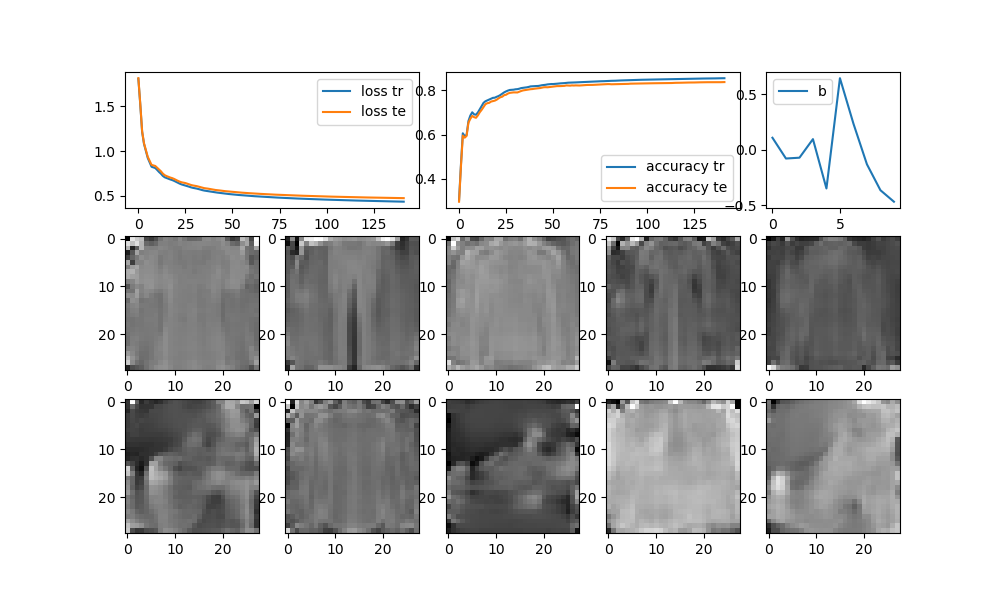

In [198]:
animate(scores, Ws, bs)

In [199]:
# REGRESJA DO ETYKIET ONE-HOT
# MA WIĘCEJ SENSU NIŻ REGRESJA DO NUMERU KLASY

# BUDUJEMY GRAF OBLICZEŃ
reg = LinearRegression()

# INICJALIZACJA PARAMETRÓW
# KLUCZE ZGODNE Z METODĄ 'EPOCH', GŁÓWNIE DLA NASZEJ WYGODY
initial_theta = {
    "W": np.zeros((FMNIST_X_tr.shape[1], FMNIST_Y_tr.shape[1]), dtype=np.float),
    "b": np.zeros(FMNIST_Y_tr.shape[1], dtype=np.float)
}

# OPTIMIZER
optimizer = Adam(
    initial_params=initial_theta,
    learning_rate=0.01,
    beta1=0.9,
    beta2=0.999,
    epsilon=1e-8,
)

# JEDNA ITERACJA PĘTLI TRENOWANIA
# OBLICZAMY GRADIENT PO PARAMETRACH
# UŻYWAMY PEŁNEGO ZBIORU TRENINGOWEGO
def train():
    theta = optimizer.get_params()
    grad = reg.epoch(
        X=FMNIST_X_tr,
        Y=FMNIST_Y_tr,
        W=theta["W"],
        b=theta["b"]
    )
    optimizer.step(grad)

# OBLICZAMY WYNIK - LOSS ORAZ ACCURACY
def score():
    theta = optimizer.get_params()
    W, b = theta["W"], theta["b"]
    return np.array((
        reg.loss(FMNIST_X_tr, FMNIST_Y_tr, W, b),
        reg.loss(FMNIST_X_te, FMNIST_Y_te, W, b),
        np.mean(np.argmax(reg.predict(FMNIST_X_tr, W, b), axis=1) == np.argmax(FMNIST_Y_tr, axis=1)),
        np.mean(np.argmax(reg.predict(FMNIST_X_te, W, b), axis=1) == np.argmax(FMNIST_Y_te, axis=1))
    ))

# UCZENIE - U MNIE TRWA OK. 2 MINUTY
N_EPOCHS = 143
scores = np.zeros((N_EPOCHS, 4), dtype=np.float)
Ws = np.zeros((N_EPOCHS, 10, 28, 28), dtype=np.float)
bs = np.zeros((N_EPOCHS, 10), dtype=np.float)
for i in range(N_EPOCHS):
    train()
    Ws[i] = optimizer.get_params()["W"].T.reshape(10,28,28)
    bs[i] = optimizer.get_params()["b"]
    scores[i] = score()
    gc.collect() # Memory Error, ponieważ python
    print("epoch {}".format(i), end='\r')

<IPython.core.display.Javascript object>


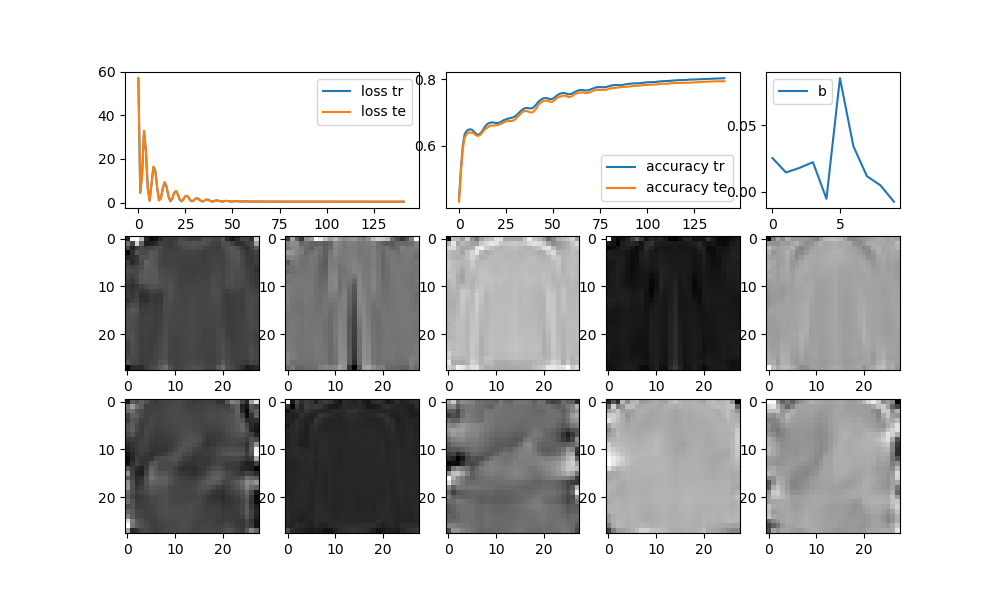

In [200]:
animate(scores, Ws, bs)